# **인공지능기초 중간과제: 컴퓨터 비전 문제**
**<div style="text-align: right"> 202120990 김도환 </div>**

* **목표:** \
간단한 컨볼루션 신경망(CNN)을 사용하여 이미지 분류 작업을 수행합니다. 이 과제에서는 Fashion-MNIST 데이터셋을 사용합니다.


*   **과제:**
    * Fashion-MNIST 데이터셋을 로드합니다.
    * 로드한 Fashion-MNIST 데이터셋을 훈련 데이터와 테스트 데이터로 나눕니다.
    * 이미지 데이터의 형태와 클래스 레이블을 시각적으로 탐색하고 분석합니다.
 
* **데이터:**
|파일명|설명|개수|
|:---:|:---:|---:|
|train-images-idx3-ubyte.gz|패션 이미지 데이터(훈련 데이터)|60,000|
|train-labels-idx1-ubyte.gz|이미지에 대한 라벨(훈련 데이터)|60,000|
|t10k-images-idx3-ubyte.gz|패션 이미지 데이터(검증 데이터)|10,000|
|t10k-labels-idx1-ubyte.gz|이미지에 대한 라벨(검증 데이터)|10,000|

과제를 시작하기 전 사용되는 모듈을 다운로드 합니다.

In [8]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


## **1. Load Fashion Dataset**
ubyte.gz 파일을 불러올 수 있도록 `LoadFashionDataset` 클래스를 생성합니다.

In [9]:
import torch
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.datasets.vision import VisionDataset
import codecs
import gzip
import sys
from typing import Any, Callable, Dict, List, Optional, Tuple

class LoadFashionDataset(VisionDataset):
    """ubyte.gz 파일에서 데이터를 로드하기 위한 클래스.
    """
    def __init__(self, image_path: str, label_path: str) -> None:
        self.TYPEMAP = {
            8: torch.uint8,
            9: torch.int8,
            11: torch.int16,
            12: torch.int32,
            13: torch.float32,
            14: torch.float64,
        }
        self.CLASSNAME = datasets.FashionMNIST.classes
        # load image data
        self.image_data = self.load_image_data(image_path)
        # load label dada
        self.label_data = self.load_label_data(label_path)
    
    def read_binary_gzip_data_to_tensor(self, path: str) -> torch.Tensor:
        """.ubyte.gz 형식의 압축된 바이너리 파일을 읽어들여 파싱한 후, torch.Tensor 객체로 반환하는 함수.
        """
        # gzip file read
        with gzip.open(path, "rb") as f:
            data = f.read()
        # magic number parse
        magic = self.get_int(data[0:4])
        nd = magic % 256
        ty = magic // 256
        assert 1 <= nd <= 3
        assert 8 <= ty <= 14
        # determine the data type
        torch_type = self.TYPEMAP[ty]
        s = [self.get_int(data[4 * (i + 1) : 4 * (i + 2)]) for i in range(nd)]
    
        num_bytes_per_value = torch.iinfo(torch_type).bits // 8
        # The MNIST format uses the big endian byte order. If the system uses little endian byte order by default,
        # we need to reverse the bytes before we can read them with torch.frombuffer().
        needs_byte_reversal = sys.byteorder == "little" and num_bytes_per_value > 1
        parsed = torch.frombuffer(bytearray(data), dtype=torch_type, offset=(4 * (nd + 1)))
        if needs_byte_reversal:
            parsed = parsed.flip(0)
    
        return parsed.view(*s)

    def get_int(self, b: bytes) -> int:
        """바이트 배열을 16진수로 인코딩 후 정수로 반환.
        """
        return int(codecs.encode(b, "hex"), 16)
                                   
    def load_image_data(self, path: str) -> torch.Tensor:
        """이미지 데이터를 불러오는 함수.
        """
        x = self.read_binary_gzip_data_to_tensor(path)
        return x
    
    def load_label_data(self, path: str) -> torch.Tensor:
        """라벨링 데이터를 불러오는 함수.
        """
        x = self.read_binary_gzip_data_to_tensor(path)
        return x.long()

In [10]:
train_fd = LoadFashionDataset("./train-images-idx3-ubyte.gz", "./train-labels-idx1-ubyte.gz")
test_fd = LoadFashionDataset("./t10k-images-idx3-ubyte.gz", "./t10k-labels-idx1-ubyte.gz")

불러온 이미지 및 라벨링 데이터를 확인합니다.

In [11]:
print("============== Train Data ==============")
print("Image Shape: {}".format(train_fd.image_data.shape))
print("Label Shape: {}\n".format(train_fd.label_data.shape))
print("==============  Test Data ==============")
print("Image Shape: {}".format(test_fd.image_data.shape))
print("Label Shape: {}\n".format(test_fd.label_data.shape))

============== Train Data ==============
Image Shape: torch.Size([60000, 28, 28])
Label Shape: torch.Size([60000])

==============  Test Data ==============
Image Shape: torch.Size([10000, 28, 28])
Label Shape: torch.Size([10000])



이미지 데이터의 라벨을 확인합니다. (총 10개의 라벨 데이터)

In [12]:
print(train_fd.CLASSNAME)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


## **2. Data visualization**

FashionMNIST 데이터를 시각화합니다.

아래 코드는 라벨별 데이터 개수를 나타냅니다.

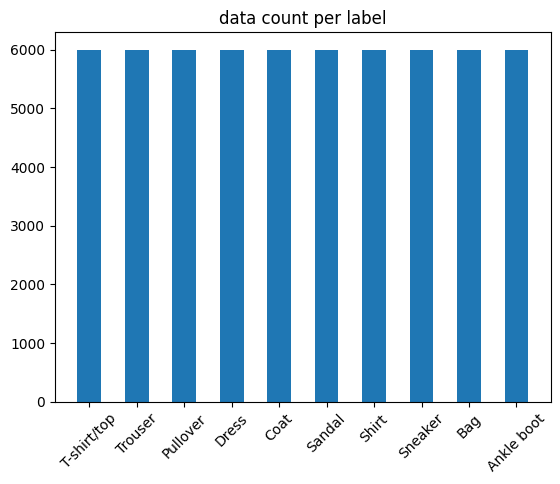

In [13]:
import matplotlib.pyplot as plt

label_vis_dict = {}
for i in range(len(train_fd.CLASSNAME)):
    label_vis_dict[train_fd.CLASSNAME[i]] = len(train_fd.label_data[train_fd.label_data == i])

plt.title("data count per label")
plt.bar(label_vis_dict.keys(), label_vis_dict.values(), width=0.5)
plt.xticks(rotation=45)
plt.show()

Fashion MNIST 데이터셋 안에 들어가있는 의류 데이터 이미지를 출력합니다.

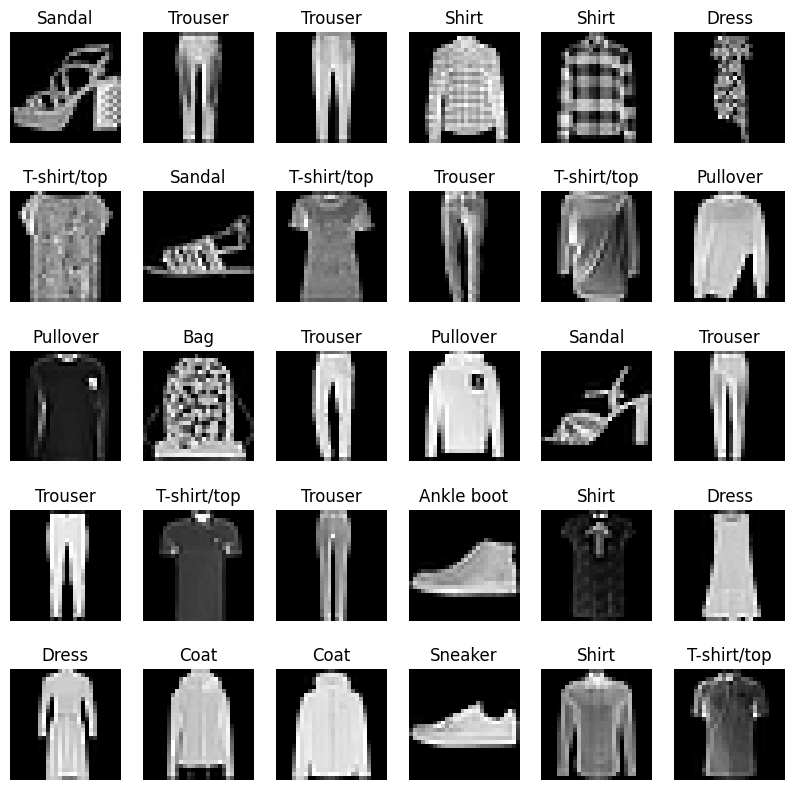

In [14]:
figure = plt.figure(figsize=(10, 10))
cols, rows = 6, 5

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_fd.image_data), size=(1,)).item()  # 이미지 데이터셋의 길이를 기준으로 샘플 인덱스를 생성합니다.
    image = train_fd.image_data[sample_idx]  # 올바른 인덱싱을 사용하여 이미지를 가져옵니다.
    label = train_fd.label_data[sample_idx].item()  # 레이블 데이터에서 해당 인덱스의 레이블을 가져옵니다.

    # 이미지를 표시할 subplot 추가
    ax = figure.add_subplot(rows, cols, i)
    plt.title(train_fd.CLASSNAME[label])
    plt.axis("off")
    plt.imshow(image.squeeze(), cmap="gray")

plt.show()

## **3. Split datasets**
데이터셋을 train, valid, test 데이터로 분할합니다.

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(train_fd.image_data, train_fd.label_data, train_size=0.7, random_state=123)
X_test, y_test = test_fd.image_data, test_fd.label_data

print("X train shape: {}\ny train shape: {}\n".format(X_train.shape, y_train.shape))
print("X valid shape: {}\ny valid shape: {}\n".format(X_valid.shape, y_valid.shape))
print("X  test shape: {}\ny  test shape: {}".format(X_test.shape, y_test.shape))

X train shape: torch.Size([42000, 28, 28])
y train shape: torch.Size([42000])

X valid shape: torch.Size([18000, 28, 28])
y valid shape: torch.Size([18000])

X  test shape: torch.Size([10000, 28, 28])
y  test shape: torch.Size([10000])


## **4. Data preprocessing**

데이터를 모델 인풋 형식에 맞게 전처리 합니다.

In [16]:
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28).float()/255
X_valid = X_valid.reshape(X_valid.shape[0], 1, 28, 28).float()/255
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28).float()/255

In [17]:
print(f"X train shape: {X_train.shape}\nX valid shape: {X_valid.shape}\nX  test shape: {X_test.shape}")

X train shape: torch.Size([42000, 1, 28, 28])
X valid shape: torch.Size([18000, 1, 28, 28])
X  test shape: torch.Size([10000, 1, 28, 28])


## **5. Create train, valid dataloader**
train과 valid 데이터에 대한 DataLoader 객체를 생성합니다.

In [18]:
import os
from torch.utils.data import TensorDataset
sys.path.append(os.path.dirname(os.path.abspath("")))
import param

train_dataset = TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=param.batch_size,
    shuffle=True,
    num_workers=param.num_workers,
)

valid_dataset = TensorDataset(X_valid, y_valid)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=param.batch_size,
    shuffle=True,
    num_workers=param.num_workers
)

/home/codespace/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## **6. Create convolution neural network**

컨볼루션 신경망 클래스를 정의합니다.

`CNN` 클래스는 두 개의 컨볼루션 레이어와 하나의 전결합층을 포함합니다.

컨볼루션 레이어의 활성화함수는 ReLU 함수를 사용하였으며, 맥스 풀링 레이어를 통해 특징 맵을 다운샘플링하였습니다.

이후 전결합층으로 이어지고, 최종적으로 10개의 출력 노드를 통해 결과가 출력됩니다.

In [19]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # 첫 번째 층
        # Img shape =  (?, 1, 28, 28)
        #      Conv => (?, 32, 28, 28)
        #      Pool => (?, 32, 12, 12)
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # 두 번째 층
        # Img shape =  (?, 32, 12, 21)
        #      Conv => (?, 64, 12, 12)
        #      Pool => (?, 64, 4, 4)
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Flatten
        self.flatten = nn.Flatten()
        # 전결합층 4*4*64 inputs -> 10 outputs
        self.fc = torch.nn.Linear(4*4*64, 10, bias=True)

        # 전결합층 한정으로 가중치 초기화
        # torch.nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CNN().to(device)

In [20]:
from torchsummary import summary

summary(model, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]             832
              ReLU-2           [-1, 32, 24, 24]               0
         MaxPool2d-3           [-1, 32, 12, 12]               0
            Conv2d-4             [-1, 64, 8, 8]          51,264
              ReLU-5             [-1, 64, 8, 8]               0
         MaxPool2d-6             [-1, 64, 4, 4]               0
           Flatten-7                 [-1, 1024]               0
            Linear-8                   [-1, 10]          10,250
Total params: 62,346
Trainable params: 62,346
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.39
Params size (MB): 0.24
Estimated Total Size (MB): 0.64
----------------------------------------------------------------


## **7. Define optimizer & loss function**

옵티마이저와 손실함수를 정의합니다.
옵티마이저는 `Adam`을 사용하고, 손실함수는 `CrossEntropyLoss`를 사용합니다.

Adam의 학습률은 `param.py`에서 정의한 `learning_rate`입니다.

In [21]:
# optimizer (adam optmizer)
optimizer = torch.optim.Adam(model.parameters(), lr=param.learning_rate)

# loss function (cross entropy loss function)
criterion = torch.nn.CrossEntropyLoss().to(device)

## **8. Model training**

모델 학습을 진행합니다.
학습 에폭 수는 `param.py`에서 정의한 `epochs`를 따라갑니다.

매 에폭 마다 `batch_size`만큼의 데이터셋을 모델에 입력하여 학습 및 검증을 진행합니다.
이후 손실함수를 계산하고 역전파를 통해 모델의 파라미터를 업데이트합니다.
학습 과정에서는 훈련 데이터 및 검증 데이터에 대한 손실 및 정확도를 기록하고, 이를 `history`에 저장합니다.


In [22]:
history = {"train_loss":[], "train_acc":[], "valid_loss":[], "valid_acc":[]}

for epoch in range(param.epochs):
    # === model train ===
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0
    for X, y in train_loader:
        # 0. initialize gradient to zero
        optimizer.zero_grad()

        # 1. move to dataset device
        X, y = X.to(device), y.to(device)
        
        # 2. predict
        y_pred = model(X)

        # 3. calculate loss function
        loss = criterion(y_pred, y)

        # 4. backpropagation
        loss.backward()

        # 5. gradient descent
        optimizer.step()

        # 6. save loss & accuracy
        train_loss += loss.item()
        _, pred = torch.max(y_pred.data, 1)
        train_total += y.size(0)
        train_correct += (pred == y).sum().item()
    train_loss /= len(train_loader.dataset)
    train_acc = 100.*train_correct/train_total
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)

    # === model validation ===
    model.eval()
    valid_loss, valid_correct, valid_total = 0, 0, 0
    with torch.no_grad():
        for X, y in valid_loader:
            # 1. move to dataset device
            X, y = X.to(device), y.to(device)

            # 2. predict
            y_pred = model(X)

            # 3. calculate loss function
            loss = criterion(y_pred, y)

            # 4. save loss & accuracy
            valid_loss += loss.item()
            _, pred = torch.max(y_pred.data, 1)
            valid_total += y.size(0)
            valid_correct += (pred == y).sum().item()
    valid_loss /= len(valid_loader.dataset)
    valid_acc = 100.*valid_correct/valid_total
    history["valid_loss"].append(valid_loss)
    history["valid_acc"].append(valid_acc)
    
    print(f"[Epoch: {epoch+1:3d}] <TRAIN> loss: {train_loss:.9f}, acc: {train_acc:5.2f}%", end="")
    print(f" | <VALID> loss: {valid_loss:.9f}, acc: {valid_acc:5.2f}%")
        

[Epoch:   1] <TRAIN> loss: 0.025971096, acc: 71.68% | <VALID> loss: 0.017764912, acc: 79.27%
[Epoch:   2] <TRAIN> loss: 0.016189751, acc: 81.28% | <VALID> loss: 0.015069672, acc: 82.84%
[Epoch:   3] <TRAIN> loss: 0.014226042, acc: 83.85% | <VALID> loss: 0.014367168, acc: 83.99%


KeyboardInterrupt: 

`history`에 저장한 손실 및 정확도 값을 시각화합니다.

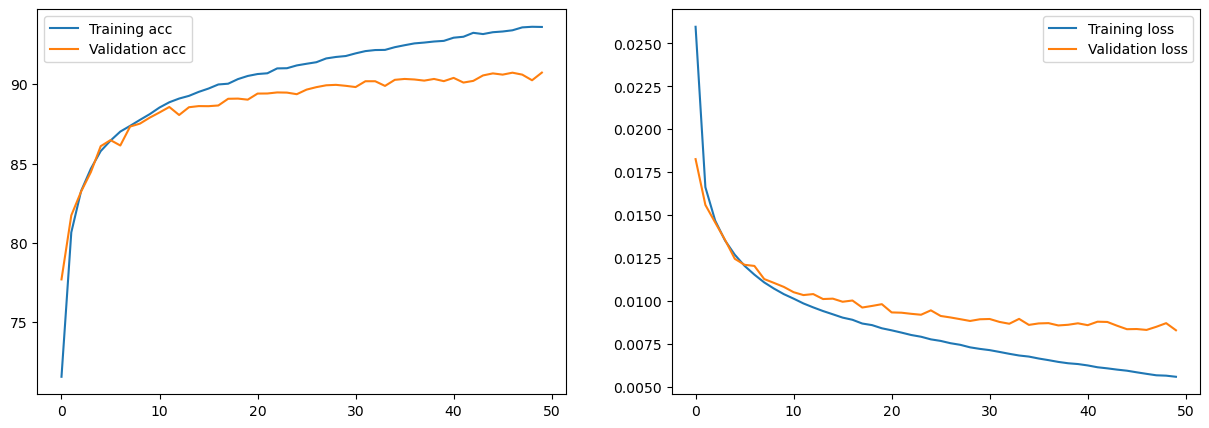

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(history["train_acc"], label="Training acc")
plt.plot(history["valid_acc"], label="Validation acc")
plt.legend()
plt.subplot(122)
plt.plot(history["train_loss"], label="Training loss")
plt.plot(history["valid_loss"], label="Validation loss")
plt.legend()
plt.show()

학습 데이터는 손실 값이 계속해서 낮아지는 모습이지만, 검증 데이터는 특정 에폭부터 큰 변화 없는것을 알 수 있습니다.


모델 훈련을 마쳤으니 테스트 데이터셋을 통해 모델 평가를 진행합니다.

## **9. Model Validation**

Test Dataset을 사용해 모델 평가를 진행합니다.

In [ ]:
model.eval()
X_test, y_test = X_test.to(device), y_test.to(device)
y_pred = model(X_test)

# calculate loss
loss = criterion(y_pred, y_test)
# calculate accuracy
_, pred = torch.max(y_pred.data, 1)
accuracy = 100.*(pred == y_test).sum().item() / len(pred)

print(f"Test loss\t: {loss.item():.9f}\nTest accuracy\t: {accuracy:5.2f}%")

Test loss	: 0.276732534
Test accuracy	: 90.37%


테스트 데이터셋을 사용하여 모델을 평가한 결과, 모델의 정확도가 위와 같이 나타났습니다. 이는 모델이 테스트 데이터셋에 대해 우수한 성능을 보여준다는 것을 의미합니다.


이제 각 라벨에 따른 정확도가 어떻게 나타났는지 그래프를 통해 확인해보겠습니다.

In [ ]:
result_vis_dict = {"label":test_fd.CLASSNAME, "correct":[], "wrong":[]}

for i in range(len(test_fd.CLASSNAME)):
    y_indexes = (y_test == i).nonzero(as_tuple=True)[0]
    correct, wrong = 0, 0
    for j in range(len(y_indexes)):
        if pred[y_indexes[j]]==y_test[y_indexes[j]]:
            correct += 1
        else:
            wrong += 1
    result_vis_dict["correct"].append(correct)
    result_vis_dict["wrong"].append(wrong)

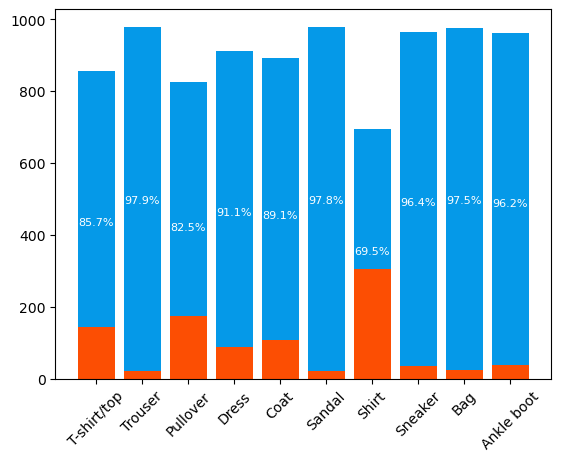

In [ ]:
fig, ax = plt.subplots()


ax.bar(test_fd.CLASSNAME, result_vis_dict["correct"], label="Correct", color="#0599e8")
ax.bar(test_fd.CLASSNAME, result_vis_dict["wrong"], label="Wrong", color="#fc4e03")
plt.xticks(rotation=45)

# write accuracy on a graph 
for i in range(len(result_vis_dict['label'])):
    ax.text(result_vis_dict['label'][i], result_vis_dict["correct"][i]/2, str(result_vis_dict['correct'][i]/10) + '%', fontsize = 8, horizontalalignment='center', color = 'w')

위 그래프를 확인해보면 `Trouser`, `Sandal`, `Sneaker`, `Bag`, `Ankle boot`에 대해서는 높은 정확도를 띄는 반면, `T-shirt/top`, `Pullover`, `Dress`, `Coat`, `Shirt`에 대해서는 비교적 높은 오답률을 보이는 것을 확인할 수 있습니다.